# <center>Feature Extraction : Gray Level Co-occurrence Matrix (GLCM) in Coffee Bean Dataset</center>

## Deskripsi Data

In [1]:
import numpy as np 
import cv2 
import os
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

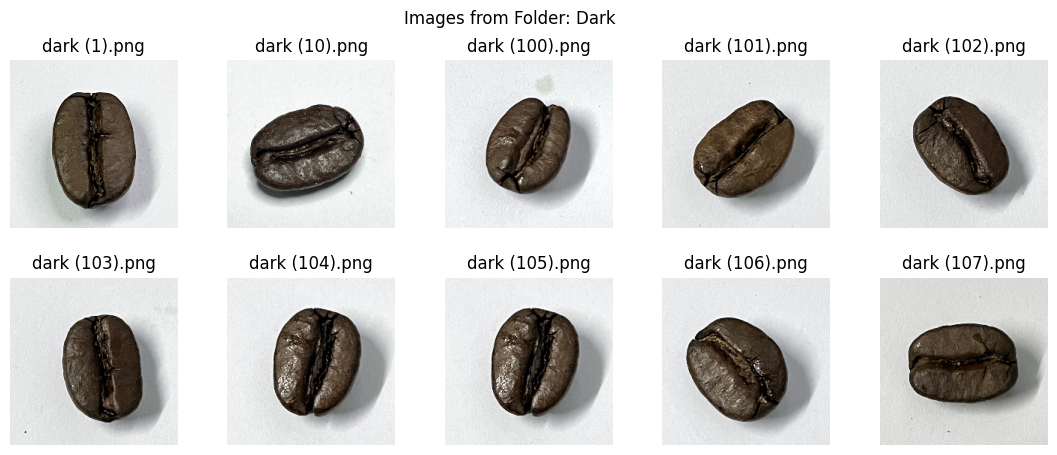

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# Menampilkan Gambar Dataset
def show_images_in_folders(root_folder, num_images_per_folder=10):
    fig = plt.figure(figsize=(15, 5))

    folders = os.listdir(root_folder)
    total_folders = len(folders)

    for i, folder in enumerate(folders, 1):
        folder_path = os.path.join(root_folder, folder)
        grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.5)

        image_count = 0
        for ax, filename in zip(grid, os.listdir(folder_path)):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    ax.set_title(filename)
                    ax.axis('off')
                    image_count += 1

                    if image_count >= num_images_per_folder:
                        break

        plt.suptitle(f"Images from Folder: {folder}")
        plt.show()

    
root_folder = "DATASET/train"
show_images_in_folders(root_folder, num_images_per_folder=10)

Dataset berisi gambar dari hasil pemotretan biji kopi yang telah dipanggang di "JJ Mall Jatujak’s, Bona Coffee.
1. Ada empat tingkat pemanggangan: tidak dipanggang (green), ringan (lightly roasted), medium (medium roasted), dan gelap (dark roasted).
2. Jenis biji kopi yang digunakan termasuk Laos Typica Bolaven (Coffea arabica), Doi Chaang (Coffea Arabica), dan Brazil Cerrado (Coffea Arabica).
3. Pengambilan foto menggunakan iPhone 12 Mini dengan kamera belakang 12 megapiksel, mode Ultra-wide, dan WideCamera.
4. Kamera diatur pada lokasi dengan bidang sejajar dengan jalur objek saat foto diambil.
5. Gambar-gambar disimpan dalam format PNG.
6. Total terdapat 4800 foto yang terklasifikasi dalam 4 tingkat pemanggangan.
7. Ada 1200 foto di bawah setiap tingkat pemanggangan.
8. Gambar dalam dataset telah diubah ukurannya menjadi bentuk persegi dengan dimensi 224x224 piksel.

## Convert ke Grayscale

In [7]:
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")

In [18]:
dataset_dir = "DATASET/" 

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            
            imgs.append(gray)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)


[##########] folder : test/Dark/ ----> file : dark (99).pngg
[##########] folder : test/Green/ ----> file : green (99).pngg
[##########] folder : test/Light/ ----> file : light (99).pngg
[##########] folder : test/Medium/ ----> file : medium (99).pngg
[##########] folder : train/Dark/ ----> file : dark (99).pngg
[##########] folder : train/Green/ ----> file : green (99).pngg
[##########] folder : train/Light/ ----> file : light (99).pngg


In [19]:
# Save processed images
for i, img in enumerate(imgs):
    output_filename = f"processed_img_{i}.png"
    cv2.imwrite(os.path.join(output_dir, output_filename), img)

print("Processed images saved in:", output_dir)

Processed images saved in: processed_images


In [20]:
output_dir = "processed_images"
os.makedirs(output_dir, exist_ok=True)

## Display Hasil Image Convertion ke Grayscale

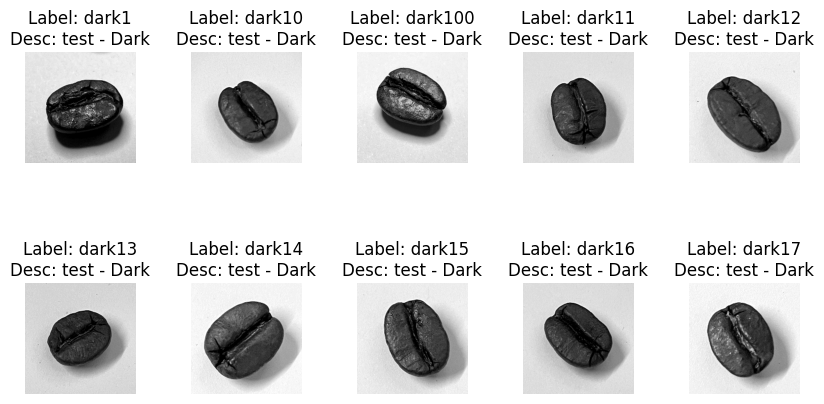

In [24]:
num_images_to_preview = 10

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for ax, img, label, desc in zip(axes.flatten(), imgs[:num_images_to_preview], labels[:num_images_to_preview], descs[:num_images_to_preview]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}\nDesc: {desc}")
    ax.axis('off')

plt.show()

## Ekstraksi Fitur Menggunakan Gray Level Co-occurrence Matrix (GLCM)

Setelah di convert ke Gray Image, Selanjutnya kita dapat mencari matrix GLCM dan metric texture keseluruhan citra kopi dengan menggunakan fungsi `greycomatrix()` dan `greycoprops()` pada library Scikit-Image,

In [25]:
from skimage.feature import graycomatrix, graycoprops

Sudut yang digunakan adalah 0, 45, 90 dan 135 untuk pada masing-masing metric texture (dissimilarity, correlation, homogeneity, contrast, ASM, energy)

In [29]:
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
# Fungsi calc_glcm_all_agl() digunakan untuk mendapatkan 24 feature data untuk sudut 0, np.pi/4, np.pi/2, 3*np.pi/4 dalam radian.
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = graycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
# Hasil 24 feature data tersimpan pada list glcm_features

properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

Sehingga untuk tiap citra kopi akan dihasilkan 24 feature data yang didapatkan dari 4 variasi sudut dengan 6 variasi metric feature.

## Tabel Hasil GLCM

Selanjutnya kita ubah format data glcm_features dari list menjadi Dataframe menggunakan library pandas. Dengan diubah kedalam bentuk dataframe, data metric texture GLCM dapat dilihat secara tabular menggunakan fungsi `pd.DataFrame()`

In [30]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

In [31]:
glcm_df.to_csv("glcm_coffee_dataset.csv")

In [32]:
glcm_df.head(7)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,16.604595,19.389339,18.261538,18.843926,0.923580,0.907286,0.916159,0.909117,0.166503,0.145953,...,1512.184793,0.001518,0.000952,0.000932,0.001150,0.038958,0.030849,0.030532,0.033919,dark1
1,11.679835,11.303657,11.736240,13.159876,0.934318,0.937406,0.932682,0.918896,0.149123,0.151378,...,893.020248,0.001011,0.000980,0.000990,0.000970,0.031789,0.031309,0.031469,0.031140,dark10
2,17.009724,17.492190,18.563071,20.217789,0.905132,0.904745,0.898871,0.881262,0.159360,0.155591,...,1623.479360,0.001027,0.001041,0.000983,0.000941,0.032041,0.032265,0.031349,0.030675,dark100
3,12.571592,12.980145,11.879199,13.493967,0.925028,0.923488,0.931855,0.916481,0.156094,0.154092,...,946.214752,0.001626,0.001550,0.001592,0.001556,0.040325,0.039374,0.039894,0.039448,dark11
4,13.462553,12.385310,13.460637,15.397707,0.938337,0.942361,0.935073,0.921174,0.129697,0.135051,...,1020.782831,0.000686,0.000688,0.000698,0.000665,0.026199,0.026236,0.026425,0.025785,dark12
5,11.473520,12.937314,12.444696,12.283740,0.942161,0.929564,0.931630,0.931451,0.136903,0.131981,...,737.344773,0.001125,0.001084,0.001101,0.001096,0.033538,0.032921,0.033187,0.033099,dark13
6,15.230981,17.270455,15.787569,14.746302,0.930857,0.920801,0.928789,0.930414,0.132508,0.122613,...,1035.526467,0.000881,0.000751,0.000831,0.000945,0.029677,0.027406,0.028836,0.030733,dark14


Nah, ditahap ini kita sudah mampu mengapatkan GLCM matrix dan menghasilkan metric texture GLCM menggunakan library Scikit-Image. Selanjutnya tabel di atas dapat diolah, seperti untuk klasifikasi, dll.